## <font color='157699'> Librerías

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import joblib
import statsmodels.api as sm

from collections import Counter
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


import sqlite3 as sql

## <font color='157699'> Carga de datos

In [2]:
# Crear conexíon 
conn = sql.connect('data/my_database.db')
#conn = sql.connect('C:\\Users\\ESTEBAN\\Desktop\\Proyecto_RRHH\\data\\db')
curr = conn.cursor()
# Leer datos para 2016 
df_2015 = pd.read_sql("SELECT * FROM v_seleccionadas", conn)

In [3]:
df_2015.head()

,EmployeeID,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,...,WorkLifeBalance_1.0,WorkLifeBalance_2.0,WorkLifeBalance_3.0,WorkLifeBalance_4.0,Education_1,Education_2,Education_3,Education_4,Education_5,renuncia2016
0,1,1.539396,-0.394825,1.405220,-0.677827,2.483743,-0.980679,-0.677540,0,0,...,0,1,0,0,0,1,0,0,0,0
1,2,-0.648748,0.099337,-0.492641,-1.078386,0.157664,-0.329864,-0.368046,0,1,...,0,0,0,1,1,0,0,0,0,1
2,3,-0.539341,0.964121,2.725878,-0.677827,-0.617696,-0.329864,-0.677540,0,1,...,1,0,0,0,0,0,0,1,0,0
3,4,0.117102,-0.888987,0.385813,0.123292,1.708383,0.158247,1.488922,1,0,...,0,0,1,0,0,0,0,0,1,0
4,5,-0.539341,0.099337,-0.885310,0.523851,-0.617696,-0.167160,-0.677540,0,0,...,0,0,1,0,1,0,0,0,0,0


In [4]:
x = df_2015.drop(columns=['renuncia2016', 'EmployeeID'])
y = df_2015['renuncia2016']

Se realizó una división tradicional 70/30, para datos de entrenamiento y de evaluación respectivamente.

## <font color ='157699'> Split train/test

In [55]:
x_train,x_test,y_train,y_test = train_test_split(x,y,shuffle = True,test_size = 0.30, random_state=123)
print('Tamaño del conjunto de entrenamiento: ', x_train.shape)
print('Tamaño del conjunto de validación: ', x_test.shape)

Tamaño del conjunto de entrenamiento:  (3015, 35)
Tamaño del conjunto de validación:  (1293, 35)


## <font color ='056938'> Modelo 1. Regresión logística

### <font color ='157699'> Regresión logística SIN balanceo de clases

In [58]:
model = LogisticRegression(random_state=123,max_iter=10000)
model.fit(x_train,y_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

In [59]:
# Métricas de desempeño train - entrenamiento
print ("Train - classification report:\n", metrics.classification_report(y_train, model.predict(x_train), digits=4))
print ("Test - classification report:\n", metrics.classification_report(y_test, model.predict(x_test), digits=4))

Train - classification report:
               precision    recall  f1-score   support

           0     0.8708    0.9920    0.9274      2609
           1     0.5116    0.0542    0.0980       406

    accuracy                         0.8657      3015
   macro avg     0.6912    0.5231    0.5127      3015
weighted avg     0.8224    0.8657    0.8157      3015

Test - classification report:
               precision    recall  f1-score   support

           0     0.8800    0.9947    0.9338      1128
           1     0.6667    0.0727    0.1311       165

    accuracy                         0.8770      1293
   macro avg     0.7733    0.5337    0.5325      1293
weighted avg     0.8528    0.8770    0.8314      1293



### <font color ='157699'> Regresión logística CON balanceo de clases

In [60]:
# Entrenar modelo
model_01 = LogisticRegression(random_state=123, class_weight="balanced", max_iter=1000) # definir el modelo
model_01.fit(x_train,y_train) # entrenar el modelo
y_pred_test_01 = model_01.predict(x_test) # predecir

In [61]:
print ("Train - classification report:\n", metrics.classification_report(y_train, model_01.predict(x_train), digits=4))
print ("Test - classification report:\n", metrics.classification_report(y_test, model_01.predict(x_test), digits=4))

Train - classification report:
               precision    recall  f1-score   support

           0     0.9413    0.6880    0.7950      2609
           1     0.2653    0.7241    0.3884       406

    accuracy                         0.6929      3015
   macro avg     0.6033    0.7061    0.5917      3015
weighted avg     0.8502    0.6929    0.7402      3015

Test - classification report:
               precision    recall  f1-score   support

           0     0.9296    0.6906    0.7925      1128
           1     0.2330    0.6424    0.3419       165

    accuracy                         0.6845      1293
   macro avg     0.5813    0.6665    0.5672      1293
weighted avg     0.8407    0.6845    0.7350      1293



## <font color ='056938'> Modelo 2. XGBoost

### <font color ='157699'> XGBoost SIN balanceo de clases

In [71]:
# Crear modelo XGBoost

bst = XGBClassifier(
    n_estimators = 2, 
    max_depth = 2, 
    learning_rate = 1, 
    objective = 'binary:logistic')

bst.fit(x_train, y_train)

# Predicciones con el conjunto de prueba
preds = bst.predict(x_test)


In [72]:
print ("Train - classification report:\n", metrics.classification_report(y_train, bst.predict(x_train), digits=4))
print ("Test - classification report:\n", metrics.classification_report(y_test, bst.predict(x_test), digits=4))

Train - classification report:
               precision    recall  f1-score   support

           0     0.8778    0.9885    0.9299      2609
           1     0.6104    0.1158    0.1946       406

    accuracy                         0.8710      3015
   macro avg     0.7441    0.5521    0.5622      3015
weighted avg     0.8418    0.8710    0.8309      3015

Test - classification report:
               precision    recall  f1-score   support

           0     0.8812    0.9867    0.9310      1128
           1     0.5000    0.0909    0.1538       165

    accuracy                         0.8724      1293
   macro avg     0.6906    0.5388    0.5424      1293
weighted avg     0.8326    0.8724    0.8318      1293



### <font color ='157699'> XGBoost CON balanceo de clases

In [73]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

# Verificar el balance de clases después de SMOTE
from collections import Counter
print(f'Distribución antes del balanceo: {Counter(y_train)}')
print(f'Distribución después del balanceo: {Counter(y_train_balanced)}')

Distribución antes del balanceo: Counter({0: 2609, 1: 406})
Distribución después del balanceo: Counter({0: 2609, 1: 2609})


In [74]:
# Crear y entrenar el modelo XGBoost con el conjunto balanceado
bst2 = XGBClassifier(n_estimators=2,
                    max_depth=2, 
                    learning_rate=1, 
                    objective='binary:logistic')
bst2.fit(x_train_balanced, y_train_balanced)

# Hacer predicciones en el conjunto de prueba
preds = bst.predict(x_test)

In [75]:
print ("Train - classification report:\n", metrics.classification_report(y_train, bst2.predict(x_train), digits=4))
print ("Test - classification report:\n", metrics.classification_report(y_test, bst2.predict(x_test), digits=4))


Train - classification report:
               precision    recall  f1-score   support

           0     0.9151    0.7846    0.8448      2609
           1     0.2776    0.5320    0.3649       406

    accuracy                         0.7506      3015
   macro avg     0.5963    0.6583    0.6048      3015
weighted avg     0.8292    0.7506    0.7802      3015

Test - classification report:
               precision    recall  f1-score   support

           0     0.9115    0.8032    0.8539      1128
           1     0.2575    0.4667    0.3319       165

    accuracy                         0.7602      1293
   macro avg     0.5845    0.6349    0.5929      1293
weighted avg     0.8280    0.7602    0.7873      1293



## <font color ='056938'> Random Forest

### <font color ='157699'> Random forest SIN balanceo de clases

In [76]:
x_train,x_test,y_train,y_test = train_test_split(x,y,shuffle = True,test_size = 0.30, random_state=123)
x_train,x_test,y_train,y_test = train_test_split(x,y,shuffle = True,test_size = 0.30, random_state=123)
print('Tamaño del conjunto de entrenamiento: ', x_train.shape)
print('Tamaño del conjunto de validación: ', x_test.shape)

Tamaño del conjunto de entrenamiento:  (3015, 35)
Tamaño del conjunto de validación:  (1293, 35)


In [23]:
ranfor = RandomForestClassifier(
            n_estimators = 150,
            criterion    = 'gini',
            n_jobs       = -1,
            random_state = 123
         )
ranfor.fit(x_train, y_train)

y_train_pred = ranfor.predict(x_train)
print('Exactitud en el entrenamiento: %.4f'  %accuracy_score(y_train, y_train_pred))

Exactitud en el entrenamiento: 0.9778


In [24]:
y_pred = ranfor.predict(x_test)
print('Exactitud en la validacion: %.4f'  %accuracy_score(y_test, y_pred))

Exactitud en la validacion: 0.9374


In [26]:
# Métricas de desempeño

print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor.predict(x_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor.predict(x_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor.predict(x_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, ranfor.predict(x_test), digits=4))

Train - Accuracy : 0.9777777777777777
Train - classification report:
               precision    recall  f1-score   support

           0     0.9885    0.9858    0.9871      2609
           1     0.9104    0.9261    0.9182       406

    accuracy                         0.9778      3015
   macro avg     0.9494    0.9560    0.9527      3015
weighted avg     0.9780    0.9778    0.9779      3015

Test - Accuracy : 0.9373549883990719
Test - classification report:
               precision    recall  f1-score   support

           0     0.9548    0.9743    0.9645      1128
           1     0.7958    0.6848    0.7362       165

    accuracy                         0.9374      1293
   macro avg     0.8753    0.8296    0.8503      1293
weighted avg     0.9345    0.9374    0.9353      1293



### <font color ='157699'> Random forest CON balanceo de clases

In [27]:
x_train_bal, x_test_bal, y_train_bal, y_test_bal = train_test_split(x, y, test_size = 0.30, random_state = 42)
print('Tamaño del conjunto de entrenamiento: ', x_train_bal.shape)
print('Tamaño del conjunto de validación: ', x_test_bal.shape)

Tamaño del conjunto de entrenamiento:  (3015, 35)
Tamaño del conjunto de validación:  (1293, 35)


In [28]:
ranfor_bal = RandomForestClassifier(
            class_weight = "balanced",
            n_estimators = 150,
            criterion    = 'gini',
            n_jobs       = -1,
            random_state = 123
         )
ranfor_bal.fit(x_train_bal, y_train_bal)

RandomForestClassifier(class_weight='balanced', n_estimators=150, n_jobs=-1,
                       random_state=123)

In [29]:
y_train_pred_bal = ranfor_bal.predict(x_train_bal)

print('Exactitud en el entrenamiento: %.4f'  %accuracy_score(y_train_bal, y_train_pred_bal))

Exactitud en el entrenamiento: 0.9741


In [30]:
y_pred_bal = ranfor_bal.predict(x_test_bal)

print('Exactitud en el validacion: %.4f'  %accuracy_score(y_test_bal, y_pred_bal))

Exactitud en el validacion: 0.9590


In [32]:
print ("Train - Accuracy :", metrics.accuracy_score(y_train_bal, ranfor_bal.predict(x_train_bal)))
print ("Train - classification report:\n", metrics.classification_report(y_train_bal, ranfor_bal.predict(x_train_bal), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test_bal, ranfor_bal.predict(x_test_bal)))
print ("Test - classification report\n:", metrics.classification_report(y_test_bal, ranfor_bal.predict(x_test_bal), digits=4))

Train - Accuracy : 0.9741293532338309
Train - classification report:
               precision    recall  f1-score   support

           0     1.0000    0.9702    0.9849      2616
           1     0.8365    1.0000    0.9110       399

    accuracy                         0.9741      3015
   macro avg     0.9182    0.9851    0.9479      3015
weighted avg     0.9784    0.9741    0.9751      3015

Test - Accuracy : 0.9590100541376644
Test - classification report
:               precision    recall  f1-score   support

           0     0.9759    0.9768    0.9764      1121
           1     0.8480    0.8430    0.8455       172

    accuracy                         0.9590      1293
   macro avg     0.9119    0.9099    0.9109      1293
weighted avg     0.9589    0.9590    0.9590      1293



## Selección de modelo

Se selecciona el modelo de random forest porque fue el que mejor Recall tuvo.

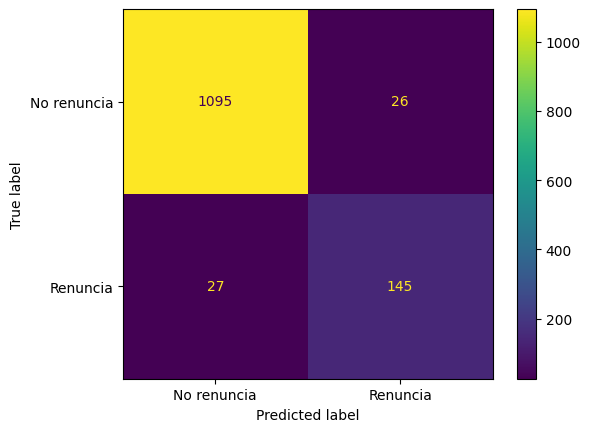

In [31]:
# Matriz de confunsión del modelo con balanceo

mc_bal = confusion_matrix(y_test_bal, y_pred_bal)
mc_display_bal = ConfusionMatrixDisplay(confusion_matrix = mc_bal, display_labels = ['No renuncia', 'Renuncia'])
mc_display_bal.plot()
plt.show()

El modelo parece tener un rendimiento sólido en la clase mayoritaria, con 1,095 predicciones correctas y solo 26 errores. Sin embargo, tiene un pequeño número de falsos negativos, lo que significa que hay empleados que en realidad renuncian pero que el modelo no logra identificar. Esto podría ser preocupante si la detección temprana de la renuncia es importante.

Por otra parte, en la clase minoritaria, el modelo también hace un buen trabajo, con 145 predicciones correctas. Sin embargo, es importante notar que cometió 27 errores donde clasificó empleados como si fueran a renunciar, pero en realidad no lo hicieron. Este tipo de error puede tener un impacto menor en comparación con los falsos negativos, dependiendo del contexto de negocio.

El modelo de random forest evaluado muestra un buen rendimiento tanto en los datos de entrenamiento como en los datos de prueba, con precisiones generales del 97.48% y 95.90%, respectivamente. Esto indica que el modelo es capaz de clasificar correctamente la gran mayoría de los ejemplos, lo que demuestra una fuerte capacidad predictiva. Además, las métricas de precisión, sensibilidad y F1 sugieren que el modelo es bastante eficiente para identificar correctamente ambas clases, aunque existen algunas diferencias importantes entre ellas debido al desequilibrio de los datos.

En el caso de la **clase mayoritaria (0)**, que representa la mayoría de los ejemplos, el modelo muestra un rendimiento sobresaliente. En ambos conjuntos de datos, el modelo alcanza una precisión cercana al 99% y una sensibilidad superior al 97%, lo que significa que es muy eficaz en identificar correctamente la clase 0. La puntuación F1 de alrededor del 98% refleja un equilibrio óptimo entre la precisión y la sensibilidad para esta clase, asegurando que las predicciones son tanto correctas como consistentes.

Por otro lado, la **clase minoritaria (1)** presenta un rendimiento ligeramente inferior. Aunque el modelo logra una alta sensibilidad (entre el 84% y el 99%) en ambos conjuntos de datos, la precisión para esta clase es menor, oscilando entre el 84% y el 85%. Esto sugiere que, si bien el modelo es muy bueno detectando la mayoría de los casos de la clase 1, también tiende a clasificar algunos ejemplos de la clase mayoritaria como clase 1 incorrectamente, lo que afecta la precisión global. Esta diferencia es particularmente visible en los datos de prueba, donde la sensibilidad y precisión son más equilibradas, pero ligeramente más bajas que en el entrenamiento, lo que podría ser una señal de un leve sobreajuste.

A nivel global, el modelo generaliza bien, con una ligera disminución en las métricas de rendimiento cuando se evalúa en los datos de prueba. Este comportamiento es esperable en modelos bien entrenados, ya que la precisión en el entrenamiento tiende a ser superior. Sin embargo, el rendimiento en la clase minoritaria podría mejorarse para evitar errores de clasificación. En este contexto, sería recomendable explorar técnicas como el ajuste de umbrales de clasificación o el uso de métodos de reequilibrio de clases para optimizar el desempeño en la clase 1 sin sacrificar el rendimiento en la clase mayoritaria.

## Hiperparámetro 1

In [33]:
# Importar librerias adicionales
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pprint

In [34]:
# Definir cuadricula de búsqueda
parameters = {
    'max_depth': [2, 5, 10, 15],
    'max_features': [0.4, 0.6, 0.8],
    'max_leaf_nodes': [14, 16, 18, 20],
    'min_samples_leaf': [8 ,10, 15, 20],
    'n_estimators': [50, 100, 150, 200]
}

In [35]:
# Búsqueda en Cuadrícula

# Modelo para tunning
ranfor_tnn = RandomForestClassifier(
    criterion = 'gini',
    n_jobs = -1,
    class_weight='balanced',
    random_state= 123
)

grid_search = GridSearchCV(ranfor_tnn, parameters, scoring = 'recall', cv=5, n_jobs=-1)

# Iniciamos la busqueda
grid_result = grid_search.fit(x_train_bal, y_train_bal)

In [44]:
print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

Best Params:  {'max_depth': 15, 'max_features': 0.4, 'max_leaf_nodes': 20, 'min_samples_leaf': 8, 'n_estimators': 200}
Best Score:  0.6164240506329115


In [45]:

print('Características usadas en el entrenamiento: ', grid_result.best_estimator_.feature_names_in_)
print('Importancia de las carcaterísticas: ', grid_result.best_estimator_.feature_importances_)

Características usadas en el entrenamiento:  ['Age' 'DistanceFromHome' 'MonthlyIncome' 'NumCompaniesWorked'
 'TrainingTimesLastYear' 'YearsAtCompany' 'YearsSinceLastPromotion'
 'BusinessTravel_Non-Travel' 'BusinessTravel_Travel_Frequently'
 'BusinessTravel_Travel_Rarely' 'Department_Human Resources'
 'Department_Research & Development' 'Department_Sales'
 'JobRole_Healthcare Representative' 'JobRole_Human Resources'
 'JobRole_Laboratory Technician' 'JobRole_Manager'
 'JobRole_Manufacturing Director' 'JobRole_Research Director'
 'JobRole_Research Scientist' 'JobRole_Sales Executive'
 'JobRole_Sales Representative' 'JobSatisfaction_1.0'
 'JobSatisfaction_2.0' 'JobSatisfaction_3.0' 'JobSatisfaction_4.0'
 'WorkLifeBalance_1.0' 'WorkLifeBalance_2.0' 'WorkLifeBalance_3.0'
 'WorkLifeBalance_4.0' 'Education_1' 'Education_2' 'Education_3'
 'Education_4' 'Education_5']
Importancia de las carcaterísticas:  [0.19853026 0.07051178 0.09135803 0.07884367 0.05831127 0.2053997
 0.04037365 0.0176875  0.

In [46]:
ranfor_optimo_tnn = grid_result.best_estimator_
print ("Train - classification report:\n", metrics.classification_report(y_train_bal, ranfor_optimo_tnn.predict(x_train_bal), digits=4))
print ("Test - classification report\n:", metrics.classification_report(y_test_bal, ranfor_optimo_tnn.predict(x_test_bal), digits=4))

Train - classification report:
               precision    recall  f1-score   support

           0     0.9564    0.8555    0.9031      2616
           1     0.4400    0.7444    0.5531       399

    accuracy                         0.8408      3015
   macro avg     0.6982    0.7999    0.7281      3015
weighted avg     0.8881    0.8408    0.8568      3015

Test - classification report
:               precision    recall  f1-score   support

           0     0.9252    0.8385    0.8797      1121
           1     0.3466    0.5581    0.4276       172

    accuracy                         0.8012      1293
   macro avg     0.6359    0.6983    0.6537      1293
weighted avg     0.8482    0.8012    0.8196      1293



---

## Exportación

In [47]:
# Asumiendo que x_train_bal es el DataFrame con los datos de entrenamiento
importancia1 = pd.DataFrame(x_train_bal.columns)  # Extrae los nombres de las columnas de tu DataFrame
importancia2 = pd.DataFrame(ranfor_optimo_tnn.feature_importances_)  # Importancias de las características
importancia = pd.concat([importancia1, importancia2], axis=1)  # Concatenar ambos DataFrames
importancia.columns = ["variable", "peso"]  # Nombrar las columnas
importancia.sort_values('peso', ascending=False, inplace=True)  # Ordenar por la importancia
print(importancia)

                             variable      peso
5                      YearsAtCompany  0.205400
0                                 Age  0.198530
2                       MonthlyIncome  0.091358
3                  NumCompaniesWorked  0.078844
1                    DistanceFromHome  0.070512
4               TrainingTimesLastYear  0.058311
8    BusinessTravel_Travel_Frequently  0.041065
6             YearsSinceLastPromotion  0.040374
25                JobSatisfaction_4.0  0.034330
26                WorkLifeBalance_1.0  0.028510
7           BusinessTravel_Non-Travel  0.017688
22                JobSatisfaction_1.0  0.016460
28                WorkLifeBalance_3.0  0.014699
10         Department_Human Resources  0.009851
20            JobRole_Sales Executive  0.008976
32                        Education_3  0.008427
9        BusinessTravel_Travel_Rarely  0.007702
11  Department_Research & Development  0.007320
24                JobSatisfaction_3.0  0.006494
23                JobSatisfaction_2.0  0

In [52]:
x

,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,...,JobSatisfaction_4.0,WorkLifeBalance_1.0,WorkLifeBalance_2.0,WorkLifeBalance_3.0,WorkLifeBalance_4.0,Education_1,Education_2,Education_3,Education_4,Education_5
0,1.539396,-0.394825,1.405220,-0.677827,2.483743,-0.980679,-0.677540,0,0,1,...,1,0,1,0,0,0,1,0,0,0
1,-0.648748,0.099337,-0.492641,-1.078386,0.157664,-0.329864,-0.368046,0,1,0,...,0,0,0,0,1,1,0,0,0,0
2,-0.539341,0.964121,2.725878,-0.677827,-0.617696,-0.329864,-0.677540,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,0.117102,-0.888987,0.385813,0.123292,1.708383,0.158247,1.488922,1,0,0,...,1,0,0,1,0,0,0,0,0,1
4,-0.539341,0.099337,-0.885310,0.523851,-0.617696,-0.167160,-0.677540,0,0,1,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,-0.867563,-0.271285,-0.919751,-0.677827,-0.617696,-0.492568,-0.677540,0,0,1,...,1,0,1,0,0,1,0,0,0,0
4304,-0.429934,0.222878,0.134735,0.924411,-0.617696,-0.329864,-0.677540,0,0,1,...,1,1,0,0,0,0,0,0,1,0
4305,-0.429934,-1.012528,-0.288973,1.725529,-0.617696,0.320951,-0.368046,0,0,1,...,0,0,0,0,1,0,0,1,0,0
4306,-0.539341,1.705365,-0.858522,-1.078386,-0.617696,-0.655272,-0.368046,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [50]:
m_rfc = RandomForestClassifier().fit(x,y)

In [51]:
joblib.dump(ranfor_optimo_tnn, "salidas\\rf_final.pkl")  
joblib.dump(m_rfc, "salidas\\m_rfc.pkl")  
 

['salidas\\m_rfc.pkl']